In [73]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import os

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [53]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [54]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()
print(Base.classes.keys())

['measurement', 'station']


In [55]:
# View all of the classes that automap found

In [56]:
# Save references to each table
msmt = Base.classes.measurement
st = Base.classes.station

In [57]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [58]:
inspector = inspect(engine)
inspector.get_table_names()
st_col   = inspector.get_columns('station')
msmt_col = inspector.get_columns('measurement')

In [59]:
for column in st_col:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [60]:
for column in msmt_col:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [62]:
# Find the most recent date in the data set.
recent = session.query(msmt.date).order_by(msmt.date.desc()).first()
print(recent)

('2017-08-23',)


Most Recent Date: 2017-08-23
Date one year ago from most recent date: 2016-08-23


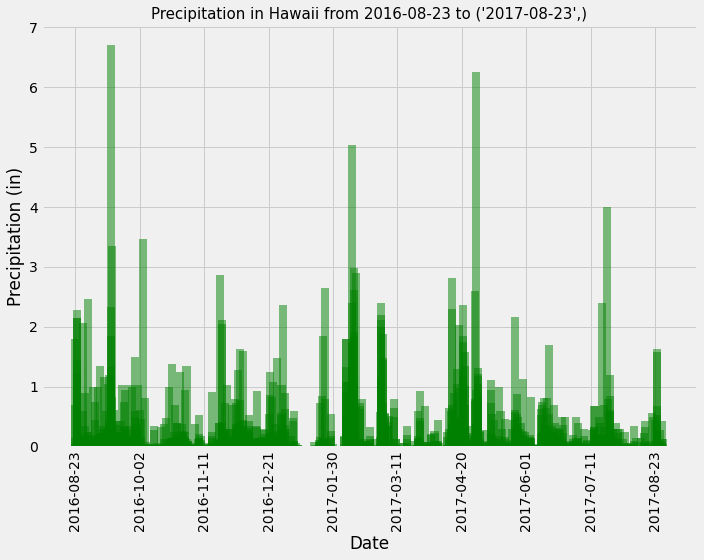

In [77]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
_12mo = dt.datetime.strptime(recent[0], '%Y-%m-%d').date()
print(f'Most Recent Date: {_12mo}')
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_yr_ago = _12mo - dt.timedelta(days=365)
print(f'Date one year ago from most recent date: {one_yr_ago}')

# Perform a query to retrieve the data and precipitation scores
msmt_date_prec = [msmt.date,msmt.prcp]
msmt_date_prec_query = session.query(*msmt_date_prec).\
                                                        filter(msmt.date>=one_yr_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(msmt_date_prec_query).set_index('date')

# Sort the dataframe by date
df.sort_index()
df.head(5)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(df.index.tolist(),df['prcp'],width = 5 ,color='green', alpha=0.5, align="center",label='Precipitation')
# x-ticks settings
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.xticks(rotation='vertical')
# title
plt.title(f'Precipitation in Hawaii from {one_yr_ago} to {recent}', fontsize=(15))
# label of the axis
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')
plt.tight_layout()
bargraph = os.path.join('.','images','precipitation_8_23_16_to_8_23_17.png')
plt.savefig(bargraph)

In [78]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [83]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(st.station).distinct().count()
print(f'There are {num_stations} stations')

There are 9 stations


In [85]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
msmt_stat = [msmt.station, func.count(msmt.station)]

ma_station = session.query(*msmt_stat).\
                                     group_by(msmt.station).\
                                     order_by(func.count(msmt.station).desc()).\
                                     all()
list(ma_station)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [95]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
ma_stations = ma_station[0][0]
msmt_stat = [func.min(msmt.tobs),func.max(msmt.tobs),func.avg(msmt.tobs)]

most_active_stations = session.query(*msmt_stat).\
                                                filter(msmt.station == ma_stations).all()
station_most_active = ma_station[0][0]
print(f'Most Active Station: {station_most_active}')
print(f'Lowest Temperture: {most_active_stations[0][0]}')
print(f'Highest Temperature: {most_active_stations[0][1]}')
print(f'Average temperature: {most_active_stations[0][2]:.1f}')

Most Active Station: USC00519281
Lowest Temperture: 54.0
Highest Temperature: 85.0
Average temperature: 71.7


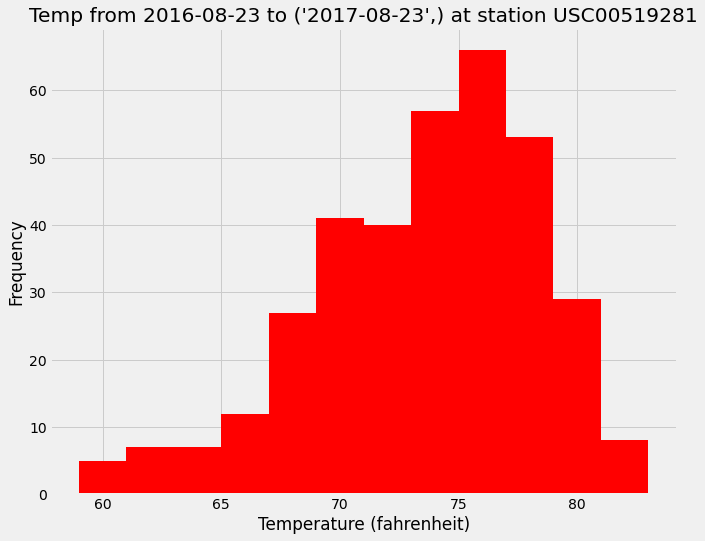

In [97]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = [msmt.tobs]

temp_obs_data = session.query(*temp_obs).\
                                      filter(msmt.station == ma_stations).\
                                      filter(msmt.date >= one_yr_ago).all()

df1 = pd.DataFrame(temp_obs_data)
df1.head(5)
fig, ax = plt.subplots(figsize=(10,8))
plt.hist(df1['tobs'],bins=12,color='red')
plt.title(f'Temp from {one_yr_ago} to {recent} at station {station_most_active}')
plt.ylabel('Frequency')
plt.xlabel('Temperature (fahrenheit)')
hist = os.path.join('.','images','Temperature_8_23_16_to_8_23_17.png')
plt.savefig(hist)

# Close session

In [ ]:
# Close Session
session.close()